Layout for Project (Template)

- Background: Discuss population models (birth rate, death rate, overall population) and how we can use stochastic models to reflect real world data

- Maths: Introduce important math components
    - OU Process: Derivation, Mean\Variance, Other Components
    - Maximum Likelihood Estimator: How it is applied to an OU Process --> Introduce scipy optimiser
    - Dickey Fuller Test: How they are used to identify mean reverting time series + the mathematical derivation behind it
    - Population Model: Show results and conclusions by applying it to the population model in paper
- Also maybe introduce Langevin model or Trading Data Example???

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statistics as stats
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import statsmodels.tsa.stattools as ts
from scipy.stats import norm
from scipy.optimize import minimize
import re

In [2]:
data = pd.read_csv("EcuadorPopulation.csv")
#data = pd.read_csv("japanfm3539.csv")
#data = pd.read_csv("Ecuador_M_3539.csv")
#data = pd.read_csv("finlandfm3539.csv")
#data = pd.read_csv("finland.csv")
#data = pd.read_csv("Ecuadorfm3539.csv")

population = data.loc[0]
birthrate = data.loc[1]
deathrate = data.loc[2]

start_year = 1970
end_year = 2018
years = [str(year) + ' [YR' + str(year) + ']' for year in range(start_year, end_year)]


def extract_data(df):
    df = df[years]  # Extract the specific row and filter columns
    df = df.reset_index()
    df.columns = ['years', 'population']
    df = df["population"].tolist()
    return df

birthrate = extract_data(birthrate)
deathrate = extract_data(deathrate)
population = extract_data(population)

'''birthrate = [i/1000 for i in birthrate]
deathrate = [i/1000 for i in deathrate]'''

#print(birthrate)
#print(deathrate)
#print(population)
#print(type(birthrate))

'birthrate = [i/1000 for i in birthrate]\ndeathrate = [i/1000 for i in deathrate]'

In [3]:
def augmented_dickey_fuller(goog):
    # Output the results of the Augmented Dickey-Fuller test for Google
    # with a lag order value of 1
    adf = ts.adfuller(goog, 1)
    print(adf)

print("DF Test for Death Rate:")
augmented_dickey_fuller(deathrate)
print("\n")
print("DF Test for Birth Rate:")
augmented_dickey_fuller(birthrate)

DF Test for Death Rate:
(-3.5804328492633766, 0.00614631862050731, 1, 46, {'1%': -3.5812576580093696, '5%': -2.9267849124681518, '10%': -2.6015409829867675}, -171.7237136955631)


DF Test for Birth Rate:
(-1.3556404952241206, 0.6033483514118225, 1, 46, {'1%': -3.5812576580093696, '5%': -2.9267849124681518, '10%': -2.6015409829867675}, -76.40979678621153)


In [4]:
'''data = pd.read_csv("wv.csv")
print(data)
start_year = 1925
end_year = 2022
years = [str(year) for year in range(start_year, end_year)]

def extract_data(df):
    df_birthrate = df["BirthRate"].tolist()
    df_deathrate = df["DeathRate"].tolist()
    df_population = df["Population"].tolist()
    return df_birthrate, df_deathrate, df_population

birthrate, deathrate, population = extract_data(data)

'''

'data = pd.read_csv("wv.csv")\nprint(data)\nstart_year = 1925\nend_year = 2022\nyears = [str(year) for year in range(start_year, end_year)]\n\ndef extract_data(df):\n    df_birthrate = df["BirthRate"].tolist()\n    df_deathrate = df["DeathRate"].tolist()\n    df_population = df["Population"].tolist()\n    return df_birthrate, df_deathrate, df_population\n\nbirthrate, deathrate, population = extract_data(data)\n\n'

In [5]:
def get_mean_birth_rate(df):
    sum = 0
    for i in range(len(df)):
        sum += df[i]
    sum = sum/len(df)
    return sum

mean = get_mean_birth_rate(birthrate)
print(mean)

def get_mean_death_rate(df):
    sum = 0
    for i in range(len(df)):
        sum += df[i]
    sum = sum/len(df)
    return sum

mean_birth_rate = get_mean_birth_rate(birthrate)
print("Mean Birth Rate from " + str(start_year) + " to " + str(end_year) + ": " + str(round(mean_birth_rate, 5)))

mean_death_rate = get_mean_death_rate(deathrate)
print("Mean Death Rate from " + str(start_year) + " to " + str(end_year) + ": " + str(round(mean_death_rate, 5)))

28.82545833333333
Mean Birth Rate from 1970 to 2018: 28.82546
Mean Death Rate from 1970 to 2018: 6.55827


In [6]:
def OU(x1, x2, dt, theta, mu, sigma):
    sigma0 = sigma**2 * (1 - np.exp(-2*mu*dt)) / (2 * mu)
    sigma0 = np.sqrt( sigma0 )
    
    prefactor = 1 / np.sqrt(2 * np.pi * sigma0**2)
    
    f =  prefactor * np.exp( -(x2 - x1 * np.exp(-mu*dt) - \
                    theta * (1-np.exp(-mu*dt)) )**2 / (2 * sigma0**2) )
    
    return f

#  Calculate the negative of the log likelihood
def log_likelihood_OU(p, X, dt):
    
    theta = p[0]
    mu = p[1]
    sigma = p[2]
    
    N = len(X)
    
    f = np.zeros( (N-1, ) )
    
    for i in range( 1, N ):
        x2 = X[i]
        x1 = X[i-1]
        
        f[i-1] = OU(x1, x2, dt, theta, mu, sigma)
    
    ind = np.where(f == 0)
    ind = ind[0]
    if ind.size > 0:
        f[ind] = 10**-8
        
    f = np.log(f)
    f = np.sum(f)
        
    return -f

#  mu and sigma must be greater than zero.  We use these contraint functions with minimze
def constraint1( p ):
    return p[1]

def constraint2( p ):
    return p[2]


#  Add constraint function to a dictionary
cons = ( {'type':'ineq', 'fun': constraint1},
         {'type':'ineq', 'fun': constraint2} )

#  Initial guess for our parameters
p0 = [1, 1, 1]

#  Call minimize

output_deathrate = minimize(log_likelihood_OU, p0, args = (deathrate, 1/len(deathrate)), constraints=cons)
print(output_deathrate)
[mu_optimised_death, gamma_optimised_death, sigma_optimised_death] = output_deathrate["x"]
print(mu_optimised_death)

#  Add constraint function to a dictionary
cons = ( {'type':'ineq', 'fun': constraint1},
         {'type':'ineq', 'fun': constraint2} )

#  Initial guess for our parameters
p0 = [1, 1, 1]

output_birthrate = minimize(log_likelihood_OU, p0, args = (birthrate, 1/len(birthrate)), constraints=cons)
print(output_birthrate)
[mu_optimised_birth, gamma_optimised_birth, sigma_optimised_birth] = output_birthrate["x"]
print(mu_optimised_birth)


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -64.09723780696177
       x: [ 4.242e+00  3.263e+00  4.433e-01]
     nit: 15
     jac: [ 7.610e-04 -5.531e-05 -5.086e-03]
    nfev: 70
    njev: 15
4.241572852228205
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -29.220790860730215
       x: [-3.018e+01  3.979e-01  9.040e-01]
     nit: 23
     jac: [ 9.918e-05 -1.398e-02 -2.539e-04]
    nfev: 102
    njev: 23
-30.177921449288803


48


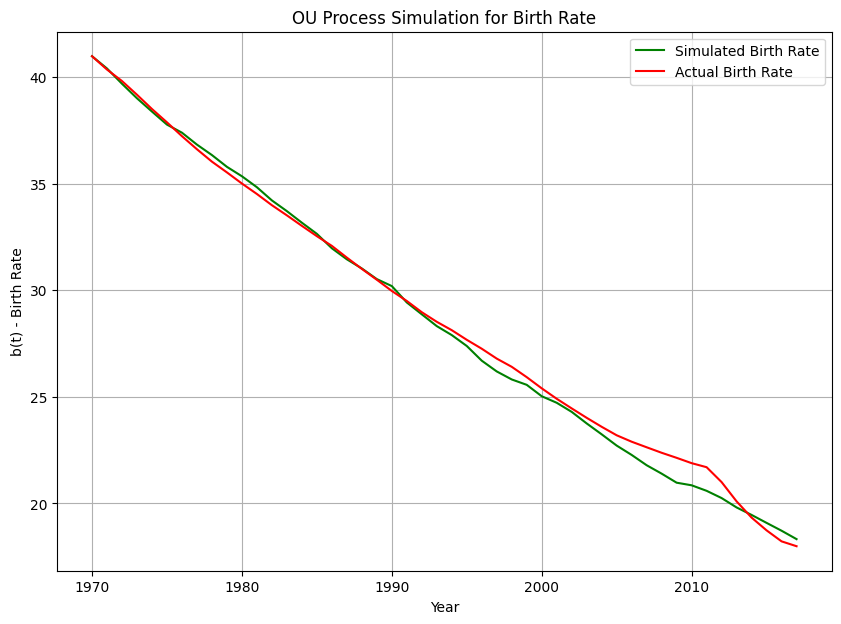

In [7]:
def plot_results_birthrate(gamma_b, sigma_b):
    
    #gamma_b = 0.7
    #b_e = mean_birth_rate
    
    b_e = mu_optimised_birth

    X_0 = birthrate[0]
    T = len(birthrate)
    dt = 1/T
    #N = int(T/dt)
    N = len(birthrate)
    print(N)
    X = np.zeros(N)
    X[0] = X_0


    X_actual = birthrate
    X_actual = np.array(X_actual)

    #print(X_actual.shape)

    x_vals = list(range(len(years)))
    year_labels = [start_year + i for i in x_vals]

    #print(X_actual)
    for t in range(1,N):
        dW = np.sqrt(dt) * np.random.normal(0,1)
        X[t] = X[t-1] + gamma_b * (b_e - X[t-1]) * dt + sigma_b * dW
        
    plt.figure(figsize=(10,7))
    plt.plot(year_labels, X, color="g", label = "Simulated Birth Rate")
    plt.plot(year_labels, X_actual, color="r", label = "Actual Birth Rate")
    plt.title("OU Process Simulation for Birth Rate")
    plt.legend()
    plt.grid(True)
    plt.xlabel("Year")
    plt.ylabel("b(t) - Birth Rate")
    
    return X, X_actual, year_labels

X, X_actual, year_labels = plot_results_birthrate(gamma_optimised_birth, sigma_optimised_birth)


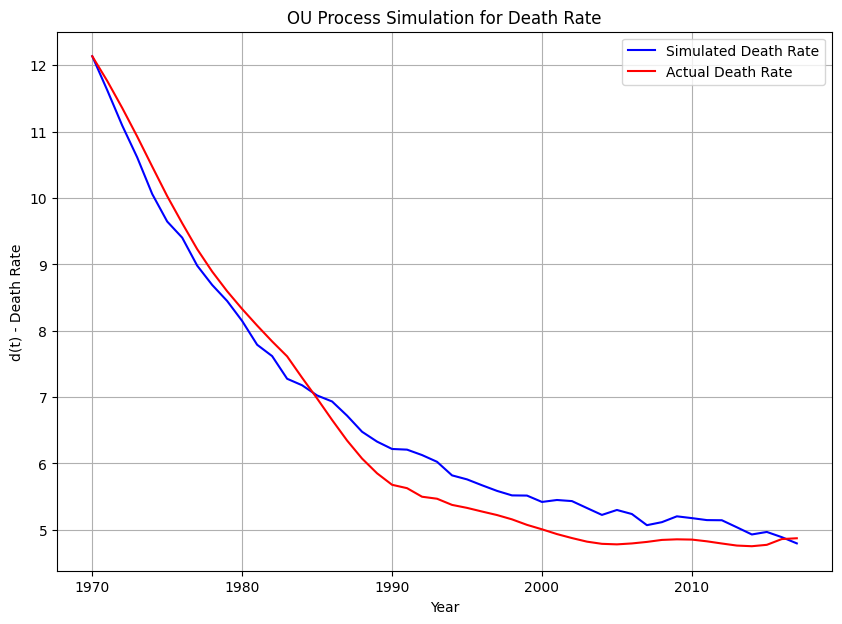

In [8]:
def plot_results_deathrate(gamma_d,sigma_d):

    d_e = mu_optimised_death
    gamma_d = gamma_optimised_death
    sigma_d = sigma_optimised_death
    
    X_0 = deathrate[0]
    T = len(deathrate)
    dt = 1/T
    N = len(deathrate)
    X = np.zeros(N)
    X[0] = X_0

    X_actual = deathrate
    X_actual = np.array(X_actual)

    x_vals = list(range(len(years)))
    year_labels = [start_year + i for i in x_vals]

    for t in range(1,N):
        dW = np.sqrt(dt) * np.random.normal(0,1)
        X[t] = X[t-1] + gamma_d * (d_e - X[t-1]) * dt + sigma_d * dW
    
    plt.figure(figsize=(10,7))
    plt.plot(year_labels, X, color="b", label = "Simulated Death Rate")
    plt.plot(year_labels, X_actual, color="r", label = "Actual Death Rate")
    plt.title("OU Process Simulation for Death Rate")
    plt.legend()
    plt.grid(True)
    plt.xlabel("Year")
    plt.ylabel("d(t) - Death Rate")
    plt.show()
    
    
    return X, X_actual, year_labels

X, X_actual, year_labels = plot_results_deathrate(gamma_optimised_death, sigma_optimised_death)


def get_results_deathrate(gamma_d,sigma_d):
    
    d_e = mu_optimised_death
    gamma_d = gamma_optimised_death
    sigma_d = sigma_optimised_death
    
    X_0 = deathrate[0]
    T = len(deathrate)
    dt = 1/T
    N = len(deathrate)
    X = np.zeros(N)
    X[0] = X_0

    X_actual = deathrate
    X_actual = np.array(X_actual)

    x_vals = list(range(len(years)))
    year_labels = [start_year + i for i in x_vals]

    for t in range(1,N):
        dW = np.sqrt(dt) * np.random.normal(0,1)
        X[t] = X[t-1] + gamma_d * (d_e - X[t-1]) * dt + sigma_d * dW    
    
    return X, X_actual, year_labels


def get_results_birthrate(gamma_b, sigma_b):

    b_e = mu_optimised_birth
    gamma_b = gamma_optimised_birth
    sigma_b = sigma_optimised_birth

    X_0 = birthrate[0]
    T = len(birthrate)
    dt = 1/T
    #N = int(T/dt)
    N = len(birthrate)
    X = np.zeros(N)
    X[0] = X_0


    X_actual = birthrate
    X_actual = np.array(X_actual)

    x_vals = list(range(len(years)))
    year_labels = [start_year + i for i in x_vals]

    for t in range(1,N):
        dW = np.sqrt(dt) * np.random.normal(0,1)
        X[t] = X[t-1] + gamma_b * (b_e - X[t-1]) * dt + sigma_b * dW
    
    return X, X_actual, year_labels


In [9]:
def sim_d(gamma_d, sigma_d):
    simulations = 100
    plt.figure(figsize=(10, 7)) 
    for i in range(simulations):
        X, X_actual, year_labels = get_results_deathrate(gamma_d, sigma_d)
        plt.plot(year_labels, X, alpha=0.25)
    
    plt.plot(year_labels, X_actual, color="g", label="Actual Death Rate")

    plt.title("Simulation for Death Rate")
    plt.legend()
    plt.grid(True)
    plt.xlabel("Year")
    plt.ylabel("D(t) - Death Rate")
    plt.show()
    
    
# Define your sliders
gamma_d_slider = widgets.FloatSlider(min=gamma_optimised_death-10, max=gamma_optimised_death+10, step=0.1, value=gamma_optimised_death, description="Rate of Reversion")
sigma_d_slider = widgets.FloatSlider(min=sigma_optimised_death - 1, max=sigma_optimised_death + 1, step=0.01, value=sigma_optimised_death, description="Volatility")

# Create a grid layout for the sliders (2x3 layout)
grid_layout = widgets.GridBox(
    children=[gamma_d_slider, sigma_d_slider],
    layout=Layout(grid_template_columns="repeat(2, 300px)", grid_template_rows="repeat(1, auto)", grid_gap="10px")
)



# Display the interactive widgets and buttons in a grid layout
ui = widgets.VBox([grid_layout])
out = widgets.interactive_output(sim_d, {
    'gamma_d': gamma_d_slider, 
    'sigma_d': sigma_d_slider
})

display(ui, out)

Output()

In [ ]:
def sim_b(gamma_b, sigma_b):
    simulations = 100
    plt.figure(figsize=(10, 7))
    for i in range(simulations):
        X, X_actual, year_labels = get_results_birthrate(gamma_b, sigma_b)
        plt.plot(year_labels, X, alpha=0.25)
    plt.plot(year_labels, X_actual, color="g")

    plt.title("Simulation for Birth Rate")
    plt.legend()
    plt.grid(True)
    plt.xlabel("Year")
    plt.ylabel("B(t) - Birth Rate")
    plt.show()
    

# Define your sliders
gamma_b_slider = widgets.FloatSlider(min=gamma_optimised_birth-10, max=gamma_optimised_birth +10, step=0.1, value=gamma_optimised_birth, description="Rate of Reversion")
sigma_b_slider = widgets.FloatSlider(min = sigma_optimised_birth - 1, max = sigma_optimised_birth+1, step=0.01, value=sigma_optimised_birth, description="Volatility")

# Create a grid layout for the sliders (2x3 layout)
grid_layout = widgets.GridBox(
    children=[gamma_b_slider, sigma_b_slider],
    layout=Layout(grid_template_columns="repeat(2, 300px)", grid_template_rows="repeat(1, auto)", grid_gap="10px")
)



# Display the interactive widgets and buttons in a grid layout
ui = widgets.VBox([grid_layout])
out = widgets.interactive_output(sim_b, {
    'gamma_b': gamma_b_slider, 
    'sigma_b': sigma_b_slider
})

display(ui, out)

Output()

In [11]:
def get_population_model(factor):
    
    
    b_e = mu_optimised_birth*factor
    sigma_b = sigma_optimised_birth*factor
    gamma_b = gamma_optimised_birth
    
    d_e = mu_optimised_death*factor
    gamma_d = gamma_optimised_death
    sigma_d = sigma_optimised_death*factor

    B_0 = birthrate[0]*factor
    D_0 = deathrate[0]*factor
    Y_0 = population[0]
    T = len(deathrate)
    #dt = 1/T
    #N = int(T/dt)
    dt = 1/T
    N = len(deathrate)
    
    Y = np.zeros(N)
    Y[0] = Y_0
    
    B = np.zeros(N)
    B[0] = B_0
    
    D = np.zeros(N)
    D[0] = D_0
    
    Y_actual = population
    Y_actual = np.array(Y_actual)

    x_vals = list(range(len(years)))
    year_labels = [start_year + i for i in x_vals]

    for t in range(1,N):
        dW1 = np.sqrt(dt) * np.random.normal(0,1) # Population Weiner Process
        dW2 = np.sqrt(dt) * np.random.normal(0,1) # Birth Rate Weiner Process
        dW3 = np.sqrt(dt) * np.random.normal(0,1) # Death Rate Weiner Process
        
        B[t] = max(B[t-1] + gamma_b * (b_e - B[t-1]) * dt + sigma_b * dW2,0)
        D[t] = max(D[t-1] + gamma_d * (d_e - D[t-1]) * dt + sigma_d * dW3,0)
    
        Y[t] = Y[t-1] + (B[t-1] - D[t-1]) * Y[t-1] * (dt) + np.sqrt(Y[t-1]*(B[t-1] + D[t-1])) * dW1
        
    return Y
    
Y = get_population_model(1/20)

C:\Users\JKelly\AppData\Local\Temp\ipykernel_12272\1981175039.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


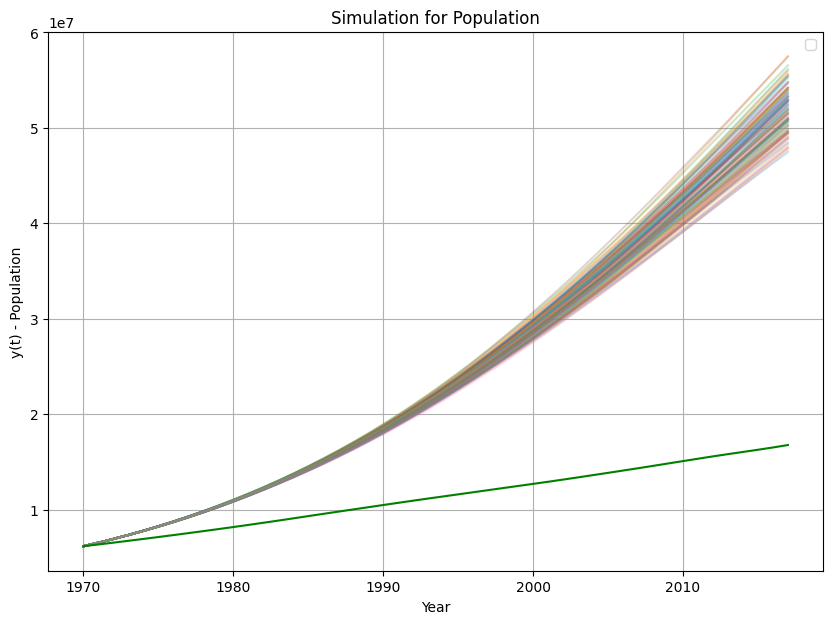

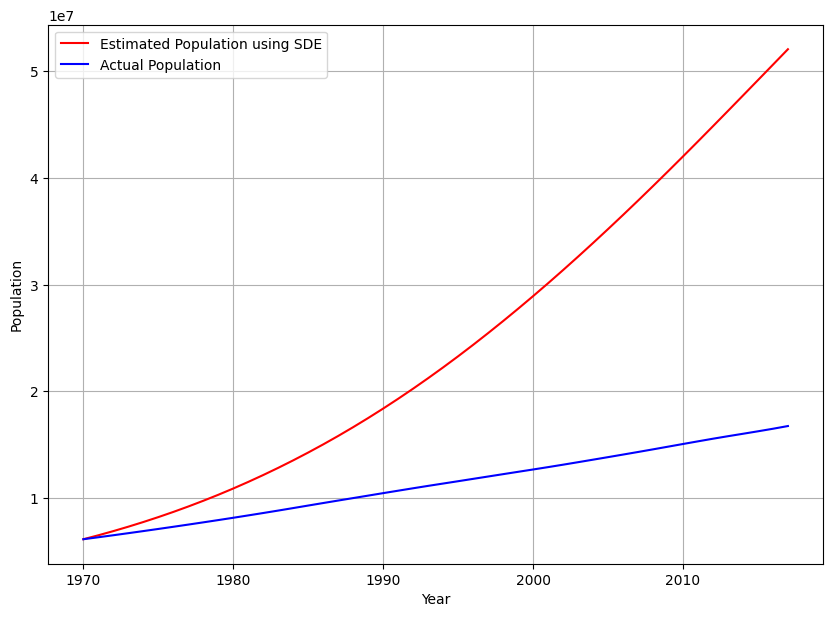

In [12]:
def main(factor):

    simulations = 100
    plt.figure(figsize=(10,7))
    Y_actual = population
    Y_actual = np.array(Y_actual)

    x_vals = list(range(len(years)))
    year_labels = [start_year + i for i in x_vals]
    Y_vault = []
    for i in range(simulations):
        Y = get_population_model(factor)
        Y_vault.append(Y)
        plt.plot(year_labels, Y, alpha=0.25)
    plt.plot(year_labels, Y_actual, color="g")

    plt.title("Simulation for Population")
    plt.legend()
    plt.grid(True)
    plt.xlabel("Year")
    plt.ylabel("y(t) - Population")
    plt.show()

    return Y_vault

Y_vault = main(0.1)

mean_pop_per_year = []
for i in range(len(Y_vault[0])):
    
    year_slice = []
    
    for j in range(len(Y_vault)):
        year_slice.append(Y_vault[j][i])
        
    mean_pop_per_year.append(np.mean(year_slice))
    
#print(mean_pop_per_year)

plt.figure(figsize=(10,7))
plt.plot(year_labels, mean_pop_per_year, color='r', label="Estimated Population using SDE")
plt.plot(year_labels, population, color="b", label="Actual Population")
plt.legend()
plt.grid(True)
plt.xlabel("Year")
plt.ylabel("Population")
plt.show()


In [13]:
# Define your sliders
factor_slider = widgets.FloatSlider(min=0.001, max=1, step=0.001, value=0.1, description="Factor")

# Create a grid layout for the sliders (2x3 layout)
grid_layout = widgets.GridBox(
    children=[factor_slider],
    layout=Layout(grid_template_columns="repeat(1, 300px)", grid_template_rows="repeat(1, auto)", grid_gap="10px")
)



# Display the interactive widgets and buttons in a grid layout
ui = widgets.VBox([grid_layout])
out = widgets.interactive_output(main, {
    'factor': factor_slider
})

display(ui, out)

Output()